# Testing the light profile : _starlet_ decomposition

In [1]:
import os
import sys
import time
import PIL
import pysap
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits

from lenstronomy.LightModel.Profiles.starlets import SLIT_Starlets
import lenstronomy.Util.util as lenstro_util
from slitronomy.Util.plot_util import nice_colorbar

%matplotlib inline

In [2]:
lin_scale = lambda x: x
log_scale = lambda x: np.log10(x)
sqrt_scale = lambda x: np.sqrt(x)

0.0 0.9333294702413144


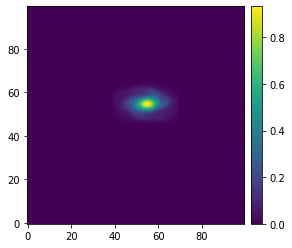

In [3]:
image = pyfits.open('data/various/M81_HST_prepared_n100.fits')[0].data
image[image < 0] = 0.
print(image.min(), image.max())

im = plt.imshow(image, origin='lower')
nice_colorbar(im)
plt.show()

## Decompose and decompose an image with starlet transform

In [4]:
starlet_profile = SLIT_Starlets(thread_count=8, fast_inverse=True, second_gen=False)

### Decompose image into starlet coefficients

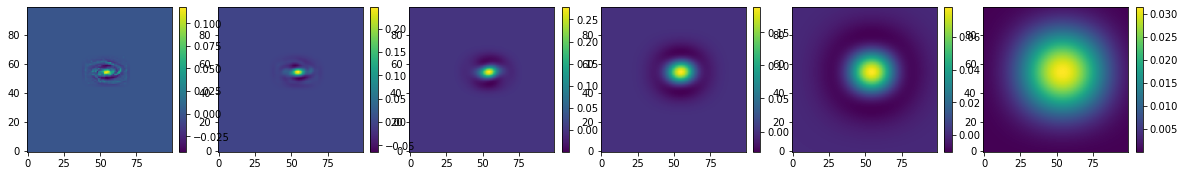

In [5]:
x, y = None, None  # normally out the coordinates grid here, not used for this profile
n_scales = 6
coeffs = starlet_profile.decomposition_2d(image, n_scales=n_scales)

fig, axes = plt.subplots(1, n_scales, figsize=(20, 4))
for i in range(coeffs.shape[0]):
    im = axes[i].imshow(coeffs[i, :, :], origin='lower')
    nice_colorbar(im)
plt.show()

### Reconcstruct image from starlet coefficients

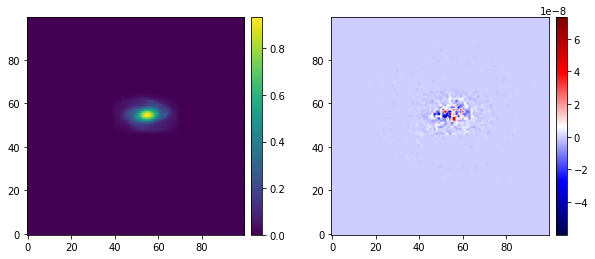

In [6]:
n_pixels = image.size
x_grid, y_grid = lenstro_util.make_grid(numPix=len(image), deltapix=1)
image_recon = starlet_profile.function(x_grid, y_grid, amp=coeffs, scale=1, 
                                       n_scales=n_scales, n_pixels=n_pixels,
                                       center_x=0, center_y=0)
image_recon = lenstro_util.array2image(image_recon)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
im = axes[0].imshow(image_recon, origin='lower')
nice_colorbar(im)
im = axes[1].imshow(image-image_recon, origin='lower', cmap='seismic')
nice_colorbar(im)
plt.show()

## Timing of different options

In [7]:
n_scales_timeit = 6

### Python-only

In [8]:
kwargs = dict(force_no_pysap=True, fast_inverse=False)

In [9]:
%timeit starlet_test = SLIT_Starlets(**kwargs)

/Users/aymericg/Documents/EPFL/PhD_LASTRO/Code/Forked/lenstronomy_forked/lenstronomy/LightModel/Profiles/starlets.py:44: UserWarning: The python package pySAP is not used for starlet operations. They will be performed using (slower) python routines.
  warnings.warn("The python package pySAP is not used for starlet operations. "


1.42 µs ± 48.9 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [10]:
starlet_test = SLIT_Starlets(**kwargs)
%timeit coeffs = starlet_test.decomposition_2d(image, n_scales=n_scales_timeit)

1.44 ms ± 29.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [11]:
starlet_test = SLIT_Starlets(**kwargs)
coeffs = starlet_test.decomposition_2d(image, n_scales=n_scales_timeit)
%timeit image_r = starlet_test.function_2d(coeffs, n_scales=n_scales_timeit, n_pixels=image.size)

1.44 ms ± 66.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### pySAP with C binding, single thread

In [12]:
kwargs = dict(thread_count=1, fast_inverse=False)

In [13]:
%timeit starlet_test = SLIT_Starlets(**kwargs)

1.23 µs ± 28.6 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [14]:
starlet_test = SLIT_Starlets(**kwargs)
%timeit coeffs = starlet_test.decomposition_2d(image, n_scales=n_scales_timeit)

1.23 ms ± 46.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [15]:
starlet_test = SLIT_Starlets(**kwargs)
coeffs = starlet_test.decomposition_2d(image, n_scales=n_scales_timeit)
%timeit image_r = starlet_test.function_2d(coeffs, n_scales=n_scales_timeit, n_pixels=image.size)

84.4 µs ± 4.42 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### pySAP with C binding, single thread, fast inverse

In [16]:
kwargs = dict(thread_count=1, fast_inverse=True)

In [17]:
%timeit starlet_test = SLIT_Starlets(**kwargs)

1.15 µs ± 43.5 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [18]:
starlet_test = SLIT_Starlets(**kwargs)
%timeit coeffs = starlet_test.decomposition_2d(image, n_scales=n_scales_timeit)

1.22 ms ± 80.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [19]:
starlet_test = SLIT_Starlets(**kwargs)
coeffs = starlet_test.decomposition_2d(image, n_scales=n_scales_timeit)
%timeit image_r = starlet_test.function_2d(coeffs, n_scales=n_scales_timeit, n_pixels=image.size)

22.3 µs ± 1.95 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### pySAP with C binding, multithread

In [32]:
kwargs = dict(thread_count=8, fast_inverse=False)

In [33]:
%timeit starlet_test = SLIT_Starlets(**kwargs)

1.12 µs ± 9.89 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [34]:
starlet_test = SLIT_Starlets(**kwargs)
%timeit coeffs = starlet_test.decomposition_2d(image, n_scales=n_scales_timeit)

784 µs ± 38 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [35]:
starlet_test = SLIT_Starlets(**kwargs)
coeffs = starlet_test.decomposition_2d(image, n_scales=n_scales_timeit)
%timeit image_r = starlet_test.function_2d(coeffs, n_scales=n_scales_timeit, n_pixels=image.size)

293 µs ± 14 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### pySAP with C binding, multithread, fast inverse

In [20]:
kwargs = dict(thread_count=8, fast_inverse=True)

In [21]:
%timeit starlet_test = SLIT_Starlets(**kwargs)

1.23 µs ± 31.7 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [22]:
starlet_test = SLIT_Starlets(**kwargs)
%timeit coeffs = starlet_test.decomposition_2d(image, n_scales=n_scales_timeit)

862 µs ± 52.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [23]:
starlet_test = SLIT_Starlets(**kwargs)
coeffs = starlet_test.decomposition_2d(image, n_scales=n_scales_timeit)
%timeit image_r = starlet_test.function_2d(coeffs, n_scales=n_scales_timeit, n_pixels=image.size)

20.4 µs ± 914 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### pySAP with C binding ( _MRStarlet_ ), multithread, fast inverse

In [24]:
kwargs = dict(thread_count=8, fast_inverse=True, use_mrstarlet=True)

In [25]:
%timeit starlet_test = SLIT_Starlets(**kwargs)

3.45 µs ± 132 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [26]:
starlet_test = SLIT_Starlets(**kwargs)
%timeit coeffs = starlet_test.decomposition_2d(image, n_scales=n_scales_timeit)

878 µs ± 68.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [27]:
starlet_test = SLIT_Starlets(**kwargs)
coeffs = starlet_test.decomposition_2d(image, n_scales=n_scales_timeit)
%timeit image_r = starlet_test.function_2d(coeffs, n_scales=n_scales_timeit, n_pixels=image.size)

19.5 µs ± 562 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### pySAP with C binding ( _MRStarlet_ ), multithread, second generation

In [28]:
kwargs = dict(thread_count=8, second_gen=True)

In [29]:
%timeit starlet_test = SLIT_Starlets(**kwargs)

3.38 µs ± 134 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [30]:
starlet_test = SLIT_Starlets(**kwargs)
%timeit coeffs = starlet_test.decomposition_2d(image, n_scales=n_scales_timeit)

1.49 ms ± 107 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [31]:
starlet_test = SLIT_Starlets(**kwargs)
coeffs = starlet_test.decomposition_2d(image, n_scales=n_scales_timeit)
%timeit image_r = starlet_test.function_2d(coeffs, n_scales=n_scales_timeit, n_pixels=image.size)

1.07 ms ± 86.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
